In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import urllib.request
import shutil
import pandas as pd
import tensorflow as tf
import keras
from google.colab import drive
from sklearn.model_selection import train_test_split

# Root directory of the project
#ROOT_DIR = os.path.abspath("../")
drive.mount('/content/gdrive')
ROOT_DIR = 'gdrive/My Drive/Colab Notebooks/mask_rcnn'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import MaskRCNN
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from pycocotools import mask


import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("COCO Model not found!")
    #utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
D2S_DATSET_DIR = 'gdrive/My Drive/dataset'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Now we warm up Gdrive caches with dataset images

In [5]:
!ls /content/gdrive/My\ Drive/dataset/images/ | wc

  31000   31000  485000


Create a custom d2sCOCO class to work-around python2 code in the default impletementation

In [0]:
class d2sCOCO(COCO):
      def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO()
        res.dataset['images'] = [img for img in self.dataset['images']]

        print('Loading and preparing results...')
        tic = time.time()
        # Check result type in a way compatible with Python 2 and 3.
        try:
            is_string =  isinstance(resFile, basestring)  # Python 2
        except NameError:
            is_string = isinstance(resFile, str)  # Python 3
        if is_string:
            anns = json.load(open(resFile))
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        print('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res

Load categories to train on. We default to training all categories.
Alternately, we could limit to training only on fruit images by replacing 
catIds assignment with this:
```
catIds= coco.getCatIds(catNms=['zucchini','lettuce','carrot','cucumber',
                               'apple_golden_delicious','apple_granny_smith',
                               'apple_red_boskoop','orange_single','clementine_single',
                               'avocado','banana_bundle','banana_single',
                               'kiwi','pear','oranges','clementine',
                               'salad_iceberg','vine_tomatoes','apple_braeburn_bundle',
                               'roma_vine_tomatoes','grapes_sweet_celebration_seedless',
                               'rocket','grapes_green_sugraone_seedless'
                               ])
```



In [6]:
annFile1= os.path.join(D2S_DATSET_DIR, 'd2s_annotations_v1.1/annotations/D2S_validation.json')
coco=d2sCOCO(annFile1)

cats = coco.loadCats(coco.getCatIds())
catIds=[cat['id'] for cat in cats]

imgids=[]
for i, value in enumerate(catIds):
    imgid=coco.getImgIds(catIds=catIds[i])
    imgids.extend(imgid)

imgids = list(set(imgids))

imgDict = coco.loadImgs(imgids)
img1 = pd.DataFrame.from_dict(imgDict)
data_list1=img1.filter(['file_name','id'])

X_train,X_val1 = train_test_split(data_list1,test_size=0.2, random_state=42,
                                 shuffle=True)
X_val,X_test = train_test_split(X_val1,test_size=0.5, random_state=42,
                                 shuffle=True)
img_id_train=X_train['id']
img_id_dev=X_val['id']
img_id_test = X_test['id']
X_train=X_train['file_name']
X_val=X_val['file_name']
X_test = X_test['file_name']
X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

loading annotations into memory...
Done (t=1.70s)
creating index...
index created!


We now proceed to create a D2SDataset object to encapsulate parsed JSON object data

In [0]:
class D2SDataset(utils.Dataset):
    def load_object(self,subset):
        
        #annotation path
        annFile=os.path.join(D2S_DATSET_DIR, 'd2s_annotations_v1.1/annotations/D2S_validation.json')
        coco=d2sCOCO(annFile)  
        
        dataset_dir=os.path.join(D2S_DATSET_DIR, 'images')
        assert subset in ["train", "val", "test"]
            
        image_dir = dataset_dir
        
        #=====need to run the coco_preprocess.py code
        if subset == "train" : 
            image_ids=img_id_train
        elif subset== "val":
            image_ids=img_id_dev
        else:
          image_ids=img_id_test
            
        # Add classes
        class_ids = sorted(coco.getCatIds())
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])


        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], iscrowd=False)))
        
        
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(self.__class__).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(self.__class__).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(self.__class__).image_reference(self, image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m
        
    
def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3]-bbox[1], bbox[2]-bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results

Now we initialize the object, and prepare it it load objects

In [15]:
dataset_train = D2SDataset()
dataset_train.load_object(subset="train")
dataset_train.prepare()


dataset_val = D2SDataset()
dataset_val.load_object(subset="val")
dataset_val.prepare()

dataset_test = D2SDataset()
dataset_test.load_object(subset="test")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [0]:
class D2SConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "D2S"
    

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    LEARNING_RATE =0.002
    
    
    #these 2 needs to set to training set / batch size
    STEPS_PER_EPOCH=2880//2
    
    #VALIDATION_STEPS=114//2

    GPU_COUNT = 1
      
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 60  # Background + fruit_classes
        
    #all following config to fit into 16G GPU
    BACKBONE = "resnet50"
    
    IMAGE_MIN_DIM = 384

    IMAGE_MAX_DIM = 384

    
    #VALIDATION_STEPS = 5

In [17]:
config = D2SConfig()
config.display()

eps = 11
lyrs = 'all'


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                73
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

'''
model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
'''
model.load_weights(os.path.join(MODEL_DIR, f'd2s20191128T0126/mask_rcnn_d2s_0011.h5'), by_name=True)

model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=eps,
                layers=lyrs)

In [0]:
s = f'mask_rcnn_d2s_{config.BACKBONE}_{config.IMAGE_MIN_DIM}x{config.IMAGE_MAX_DIM}_{lyrs}_{eps}.h5'
model_path = os.path.join(MODEL_DIR, s)
model.keras_model.save_weights(model_path)

Loading weights from  gdrive/My Drive/Colab Notebooks/mask_rcnn/logs/mask_rcnn_d2s_resnet50_384_384_all_10.h5
original_image           shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (73,)                 min:    0.00000  max: 1920.00000  float64
gt_class_id              shape: (3,)                  min:   25.00000  max:   52.00000  int32
gt_bbox                  shape: (3, 4)                min:   48.00000  max:  332.00000  int32
gt_mask                  shape: (384, 384, 3)         min:    0.00000  max:    1.00000  uint8


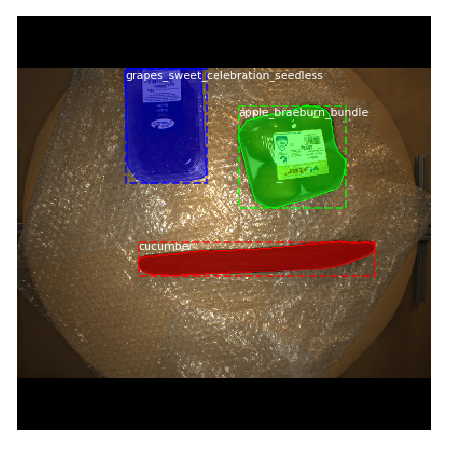

In [18]:
from mrcnn.model import log
class InferenceConfig(D2SConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_d2s_resnet50_384_384_all_10.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 73)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.94527  max:    1.77817  float32


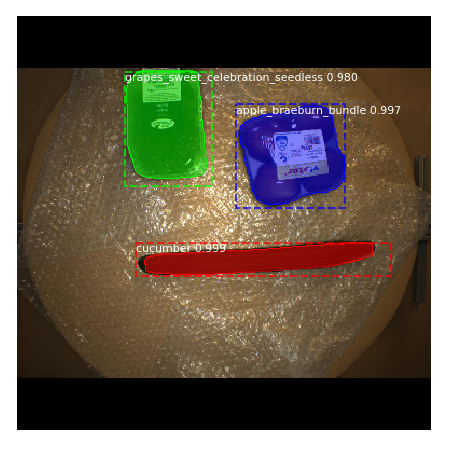

In [19]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
    
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [21]:
import time
import copy
unicode = str
def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """

    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]
    t_prediction = 0
    t_start = time.time()
    results = []

    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)
        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)
    
    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

# call evaluate     
evaluate_coco(model, dataset_test, coco, "bbox",limit=100)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.864
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.864
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [0]:
'''
# Compute VOC-Style mAP @ IoU=0.5
# Running on 300 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 300)
APs = []
AP50s = []
AP75s = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP =\
        utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_thresholds=None, verbose=0)
    APs.append(AP)

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5 )
    AP50s.append(AP)

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.75)
    AP75s.append(AP)    
print("mAP: ", np.mean(APs))
print("mAP50: ", np.mean(AP50s))
print("mAP75: ", np.mean(APs75))
'''

In [0]:
%load_ext tensorboard
%tensorboard --logdir MODEL_DIR/d2s20191128T0126